## 飞浆设计思想

描述神经网络模型的Program，由多个Block（控制流结构）构成，每个Block是由Operator（算子）和数据表示Variable（变量）构成，经过串联形成从输入到输出的计算流。
- 飞桨采用类似于编程语言的抽象语法树的形式描述用户的神经网络配置，称之为Program。构建深度学习模型的代码时，将其中的计算模块写入Program中，可以理解为Program是模型计算的集合体。一个模型可以有多个Program，比如GAN模型。
- Program 又由嵌套的 Block 构成，Block是高级语言中变量作用域的概念，Block是可以嵌套的。Block中又包括Operator 和 Variable。深度学习模型与Program、Block的关系如下所示：

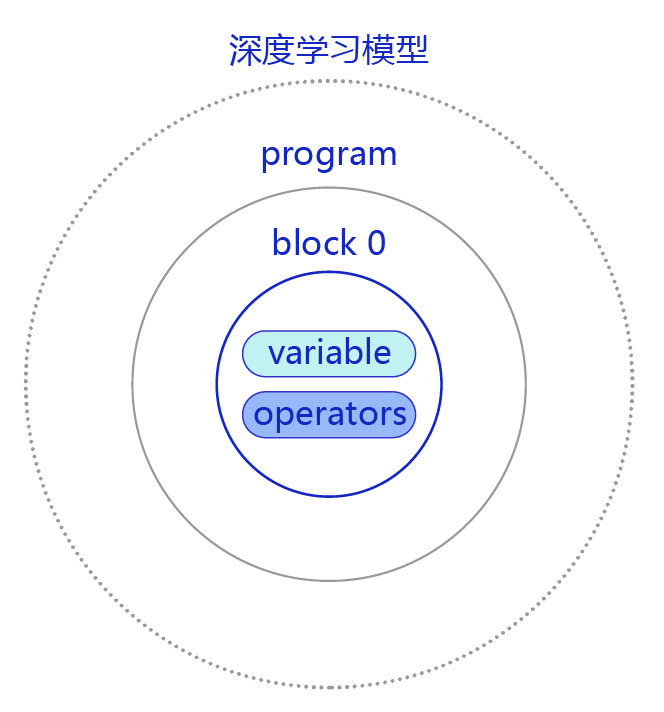

- 在一个Block中，飞桨将神经网络抽象为计算表示Operator（算子）和数据表示Variable（变量）。神经网络的每层操作均由一个或若干Operator组成，每个Operator接收一系列的Variable作为输入，经计算后输出一系列的Variable。

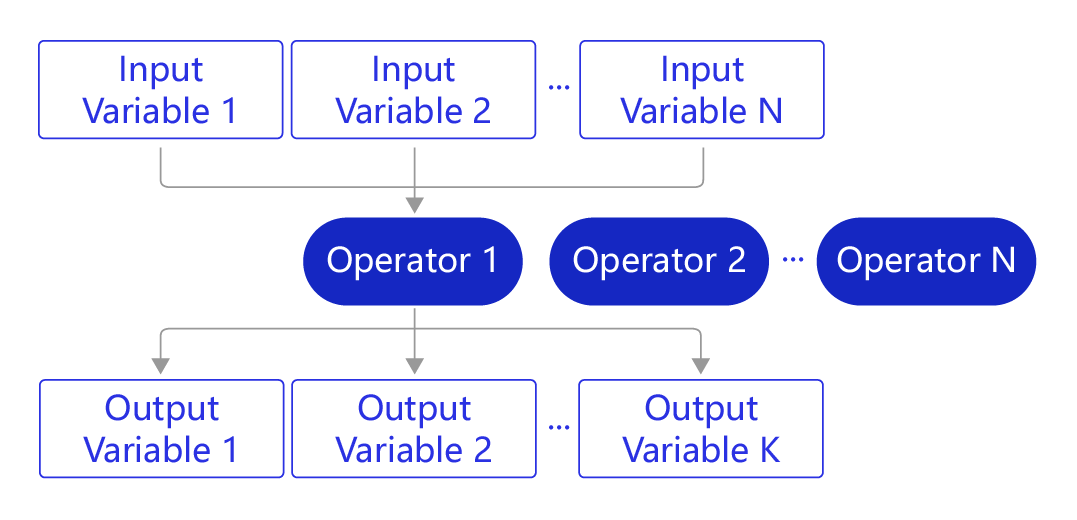

- 构建深度学习模型时，用户只需定义前向计算网络、损失函数和优化算法，框架会自动生成前向计算和梯度优化的流程，该流程由初始化程序（startup_program）与主程序(main_program)实现。
- 一个Program的集合通常包含初始化程序（startup_program）与主程序(main_program)，默认情况下，飞桨的神经网络模型都包括两个program，分别是static.default_startup_program()以及static.default_main_program()，它们共享参数。 default_startup_program 只运行一次来初始化参数，训练时，default_main_program 在每个batch中运行并更新权重。

## 飞浆前后端的整体架构

飞桨框架内部模块的逻辑结构，共有如下的7层：

1. 前端编程界面：用户使用框架的方式是基于API定义网络结构（前向计算逻辑），并控制训练过程。
2. 自动微分机制：自动完成反向逻辑，这是深度学习框架与Numpy科学计算库的本质区别。如果只是进行数学运算，大量的科学计算库均能满足需求。深度学习框架的特色是根据用户设定的前向计算逻辑，自动生产反向计算的逻辑，使得用户不用操心模型的训练过程。
3. 内部表达IR：统一表达有两个用处，一方面便于进行算子融合等计算优化，另一方面便于序列化，用于对接不同的硬件以及进行分布式训练等，即接下来的第4步和第5步。
4. 计算图优化：可以用户手工优化，也可以框架根据策略自动优化，当然后者对用户更加友好。
5. 算子序列执行：单机单卡的训练是比较简单的，根据前向和后向计算逻辑顺序执行就好。但对于单机多卡和多机多卡的分布式训练，如何并发、异步执行计算流程，并调度异构设备等问题就需要在这个环节仔细设计。
6. 算子库：框架产品最好有完备的算子库，对于99%以上的模型均有高效实现的算子可以直接使用。但由于科学的不断前进，总有新创造的模型可能会用一些新的计算函数，所以框架要允许易添加用户自定义的算子也是同样重要的，用户添加的算子同时要具备原生算子一样的训练和推理能力，并且可以在广泛的硬件上部署。
7. 后端硬件接入：框架需要与众多种类的训练和预测硬件完成对接，这些硬件接口开放的层次往往也是不同的，典型有IR子图的高层接入方式和底层编程接口接入方式，目前最新的AI编译器技术也在尝试解决这个问题。